# Shot Clustering

Both [shot charts](https://github.com/basketballrelativity/basketball_data_science/blob/master/Chapter%202/Shot%20Charts.ipynb) and [shot densities](https://github.com/basketballrelativity/basketball_data_science/blob/master/Chapter%203/Shot%20Density.ipynb) reveal how a player or team distributes their field goals. These are great introductory tools to begin to understand how an offensive player (or offense) operates. However, these tools lack context relative to the league as a whole. Classifying shots by location or type could provide insight into the style or offensive philosophy of a team or player.

One such way to classify shots is through [_k_-means clustering](https://en.wikipedia.org/wiki/K-means_clustering), which is an unsupervised algorithm that assigns observations to one of _k_ clusters. By using the two-dimensional space of shot locations, _k_-means clustering can be leveraged to classify shots into similar groups. This notebook is inspired by Section 4.2 of [Basketball Data Science with Applications in R](https://www.amazon.com/Basketball-Data-Science-Applications-Chapman-dp-1138600792/dp/1138600792/ref=mt_paperback?_encoding=UTF8&me=&qid=) (BDS), which clusters shots by location and other features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import seaborn as sns
from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

Used for the [shot densities tutorial](https://github.com/basketballrelativity/basketball_data_science/blob/master/Chapter%203/Shot%20Density.ipynb), the 2018-19 dataset of NBA shots will serve as the training set for clustering. To learn more about pulling shot location data at the game level, please see the tutorial for more details.

In [2]:
shot_df = pd.read_csv('../Chapter 3/shotchart_2018.csv')

In [3]:
shot_df['LOC_X'] = -shot_df['LOC_X']
shot_df.head()

,ACTION_TYPE,EVENT_TYPE,GAME_DATE,GAME_EVENT_ID,GAME_ID,GRID_TYPE,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,...,SHOT_ATTEMPTED_FLAG,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,TEAM_NAME,VTM
0,Jump Shot,Missed Shot,20181016,7,21800001,Shot Chart Detail,BOS,53,264,11,...,1,26,0,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612755,Philadelphia 76ers,PHI
1,Jump Shot,Missed Shot,20181016,10,21800001,Shot Chart Detail,BOS,148,207,11,...,1,25,0,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,1610612738,Boston Celtics,PHI
2,Running Layup Shot,Missed Shot,20181016,14,21800001,Shot Chart Detail,BOS,-4,18,11,...,1,1,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612738,Boston Celtics,PHI
3,Running Layup Shot,Made Shot,20181016,17,21800001,Shot Chart Detail,BOS,8,3,10,...,1,0,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612755,Philadelphia 76ers,PHI
4,Driving Layup Shot,Missed Shot,20181016,19,21800001,Shot Chart Detail,BOS,46,1,10,...,1,4,0,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612738,Boston Celtics,PHI


For this tutorial, we'll focus just on the shot location fields:
- `LOC_X`: horizontal coordinate of a shot
- `LOC_Y`: vertical coordinate of a shot

## Drawing the Court

The coordinate system for the court has its origin at the basket. Positive horizontal locations are to the right side of the basket when facing it. Positive vertical locations are away from the basket when facing it. The unit of shot locations in `LOC_X` and `LOC_Y` are tenths of a foot. So, for example, a shot location of `(LOC_X, LOC_Y) = (0, 100)` is a distance of ten feet from the basket, directly in front of it.

Armed with this information and the [locations of NBA court markings](https://en.wikipedia.org/wiki/Basketball_court), we can create a function, `draw_court`, to abstract away visualizing an NBA court to use for creating shot charts. 

In [4]:
def draw_court():
    """ draw_court draws an NBA halfcourt
    
    Returns:
    
        fig (matplotlib.figure.Figure): Figure object visualizing
            an NBA court
        axis (matplotlib.axes): Axis object visualizing an NBA
            court
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')

    # These create the straight line portions of the court markings
    plt.plot([-250, 250], [-40, -40], 'k-') # endline
    plt.plot([-250, 250], [430, 430], 'k-') # halfcourt line
    plt.plot([-250, -250], [-40, 430], 'k-') # sideline
    plt.plot([250, 250], [-40, 430], 'k-') # sideline
    
    plt.plot([-30, 30], [-10, -10], 'k-') # backboard
    plt.plot([-60, -60], [-40, 150], 'k-') # lane
    plt.plot([60, 60], [-40, 150], 'k-') # lane
    plt.plot([-80, -80], [-40, 150], 'k-') # lane
    plt.plot([80, 80], [-40, 150], 'k-') # lane
    plt.plot([-80, 80], [150, 150], 'k-') # foul line

    plt.plot([220, 220], [-40, 90], 'k-') # 3pt straight
    plt.plot([-220, -220], [-40, 90], 'k-') # 3pt straight

    # These create the several circular portions of the court markings
    three_point = Arc((0, 0), width=237.5*2, height=237.5*2, theta1=22, theta2=158, linewidth=1.5)
    top_key = Arc((0, 150), width=60*2, height=60*2, theta1=0, theta2=180, linewidth=1.5)
    bottom_key = Arc((0, 150), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5, linestyle='--')
    basket = Arc((0, 0), width=7.5*2, height=7.5*2, theta1=0, theta2=360, linewidth=1.5)
    restricted = Arc((0, 7.5), width=40*2, height=40*2, theta1=0, theta2=180, linewidth=1.5)
    half_court = Arc((0, 430), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5)

    axis.add_patch(three_point)
    axis.add_patch(top_key)
    axis.add_patch(bottom_key)
    axis.add_patch(basket)
    axis.add_patch(restricted)
    axis.add_patch(half_court)

    plt.ylim(-50, 450)
    axis.set_aspect(1.0)
    plt.axis('off')

    return fig, axis

## _k_-means Clustering

The following leverages the [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class to fit a _k_-means clustering model to shot locations. You can read more about _k_-means clustering and how scikit-learn implements the algorithm [here](https://scikit-learn.org/stable/modules/clustering.html#k-means), but the following breifly describes how _k_-means clustering functions.

For a specified number of _k_ clusters, the _k_-means algorithm separates observations into _k_ groups while minimizing the within-cluster sum-of-squares, or inertia, between observations and their corresponding cluster centroids. To initialize the algorithm, _k_ centroids are established by selecting _k_ random observations from the dataset. Then, the algorithm proceeds iteratively:

- First, observations are assigned to the closest centroid in terms of Euclidean distance
- Second, centroids are recalculated based on the new cluster members by taking the mean of all observations in the cluster

The above proceed until the centroids reach a convergence threshold. One last note is that _k_-means is not guaranteed to converge to a global minimum for inertia, and this depends on the initial centroids chosen. To combat this, smart centroid initalization or simply rerunning the algorithm with different initial centroids are effective techniques.

The following loops through several choices of _k_ and stores the inertia for each value of _k_. Inertia will always be non-increasing as the number of clusters increase, so choosing _k_ is a bit of an art that pits the reduction of inertia with against the desire for a manageable number of clusters. One rule-of-thumb is to choose _k_ based on the "elbow" in the number of clusters versus inertia plot. This "elbow" occurs when the reduction of inertia begins to plateau with increasing _k_.

In [5]:
inertia = []
for clusters in range(2, 13):
    print(str(clusters) + ' Clusters')
    kmeans = KMeans(n_clusters=clusters, random_state=0)
    kmeans.fit(shot_df[['LOC_X', 'LOC_Y']])
    print(kmeans.cluster_centers_)
    inertia.append(kmeans.inertia_)
    print('***************')

2 Clusters
[[116.719985   164.74418132]
 [-47.01847658  64.87733531]]
***************
3 Clusters
[[-123.15704265  169.38265198]
 [  -1.66843358   26.47852661]
 [ 140.21696048  156.14796251]]
***************
4 Clusters
[[-154.93176703  145.10589775]
 [  -2.04810568   26.73033667]
 [  57.67496229  223.84737934]
 [ 191.4548909    77.66441938]]
***************
5 Clusters
[[ 199.76665551   45.91630398]
 [  -0.88472636   27.40103797]
 [-197.3639161    63.170419  ]
 [ 109.80248851  207.86903913]
 [ -86.19509282  216.02032974]]
***************
6 Clusters
[[   3.52360845  232.26875666]
 [  -0.92647548   27.14393547]
 [-201.61255902   46.77494328]
 [ 201.27711673   35.14835922]
 [-128.43617405  199.0478424 ]
 [ 137.28982221  194.58777802]]
***************
7 Clusters
[[  -1.11072823   15.77865259]
 [ 140.93464327  197.55749714]
 [-132.47289879  203.15135699]
 [  -0.37006046  108.32910277]
 [ 201.21232061   35.09531867]
 [   4.23091489  255.62522318]
 [-201.78140564   46.79481031]]
***************

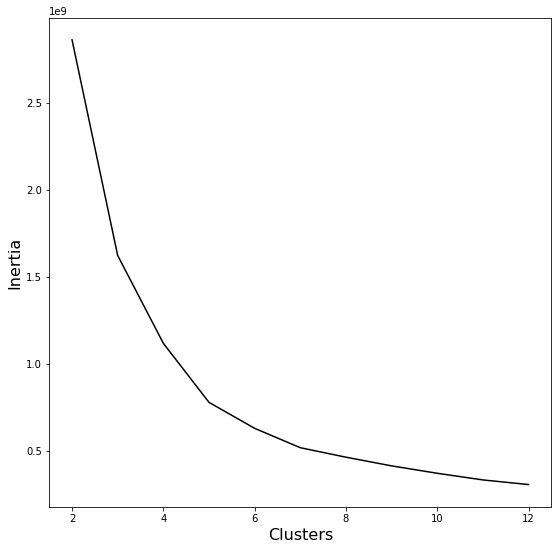

In [6]:
fig = plt.figure(figsize=(9, 9))
axis = fig.add_subplot(111, aspect='auto')
plt.plot(range(2, 13), inertia, 'k-')
plt.xlabel('Clusters', fontsize=16)
plt.ylabel('Inertia', fontsize=16)
plt.show()

There are more objective ways to select the number of clusters, but the "elbow" in the curve here appears to occur at 7 clusters. So, with 7 clusters, let's fit a final model and visualize the results.

In [7]:
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(shot_df[['LOC_X', 'LOC_Y']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

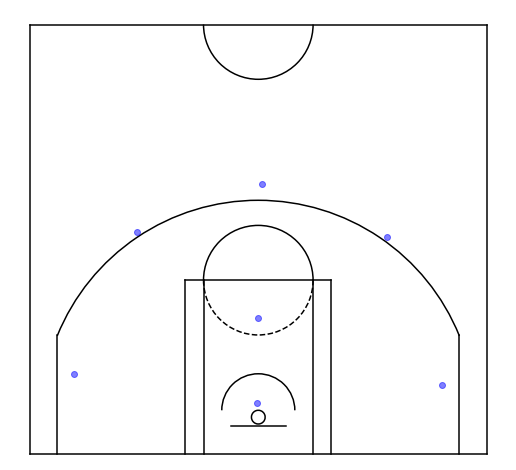

In [8]:
court, court_axis = draw_court()
for cent in kmeans.cluster_centers_:
    plt.plot(cent[0], cent[1], 'bo', alpha=0.5)

The above shows the location of the 7 cluster centroids from our model. The symmetry is pretty cool! Three centroids are nearly aligned vertically in the center of the court, with the other clusters flanking on each wing and baseline. The locations also align with basketball intuition, especially with a centroid at the basket, in the paint, and sprinkled around the perimeter.

While the figure above shows only the centroids, we can take this a step further and visualize all shots within each cluster. We can obtain the cluster that each shot belongs to through the `predict` function of our model, then color each shot by its cluster.

In [9]:
preds = kmeans.predict(shot_df[['LOC_X', 'LOC_Y']])
shot_df['cluster'] = preds

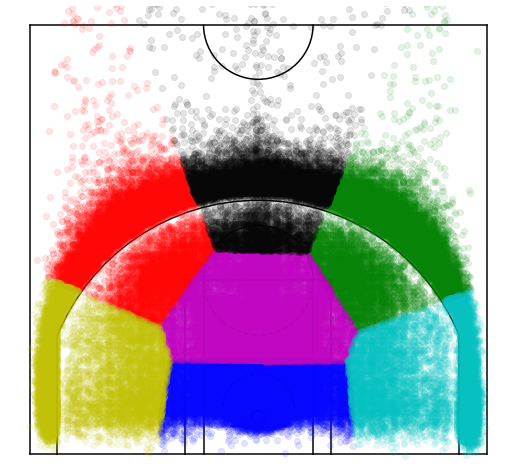

In [10]:
court, court_axis = draw_court()
cols = ['b', 'g', 'r', 'm', 'c', 'k', 'y']
for clust in range(0, 7):
    plt.plot(shot_df[shot_df['cluster']==clust]['LOC_X'], shot_df[shot_df['cluster']==clust]['LOC_Y'], cols[clust] + 'o', alpha=0.1)

Several observations jump out when visualizing the clusters in this way:

- The cluster nearest to the basket encompasses the restricted area and the low blocks, probably capturing most drives to the basket.
- One additional cluster covers the entirety of the remaining portion of the painted area, along with the immediate surroundings.
- The remaining clusters seemed equally sized and radiate around the three-point line. These clusters contain both two-point and three-point field goals.

This last point serves as the jumping off point for the rest of this notebook. While midrange two-point field goals and three-point field goals are close from a Euclidean distance point-of-view, these shots are truly distinct. In fact, the entire game has evolved to nearly eschew the midrange in favor of three-point field goals. However, using boolean variables to differentiate between two-point and three-point field goals is not appropriate in _k_-means clustering. Alternatively, we can split the dataset by shot type, and then proceed to build clustering models for each subset.

In [11]:
two_df = shot_df[shot_df['SHOT_TYPE'] == '2PT Field Goal']
three_df = shot_df[shot_df['SHOT_TYPE'] == '3PT Field Goal']

### Two-point Field Goals

In [12]:
inertia = []
for clusters in range(2, 13):
    print(str(clusters) + ' Clusters')
    kmeans = KMeans(n_clusters=clusters, random_state=0)
    kmeans.fit(two_df[['LOC_X', 'LOC_Y']])
    print(kmeans.cluster_centers_)
    inertia.append(kmeans.inertia_)
    print('***************')

2 Clusters
[[ 1.99973375e-02  1.95096706e+01]
 [-2.64353623e+00  1.35097997e+02]]
***************
3 Clusters
[[ -2.4586041   17.83975441]
 [ 90.14704877 102.89825709]
 [-67.02983373 120.12059274]]
***************
4 Clusters
[[ 114.5715478    74.84908953]
 [  -1.05701721   17.67451002]
 [-107.17443071   86.493689  ]
 [   7.10896318  145.03841363]]
***************
5 Clusters
[[  36.36302627  141.83331421]
 [  -0.65723487   18.15474046]
 [ -72.96637368  141.4649625 ]
 [-115.73387829   41.23024523]
 [ 120.23433321   57.45787161]]
***************
6 Clusters
[[  -0.91611091   12.28443103]
 [ -58.73686385  158.92737938]
 [ 120.50321913   42.777765  ]
 [-118.9722487    49.38343396]
 [  -0.27589797   78.53820927]
 [  74.0750814   152.38393028]]
***************
7 Clusters
[[  -0.67469625   75.56238774]
 [ 119.433625     36.942     ]
 [ -94.62787224  140.76608456]
 [  -0.7520027    12.07955809]
 [-115.96273679   36.08773679]
 [  -1.14169759  169.70535714]
 [  93.8063443   140.65367708]]
*********

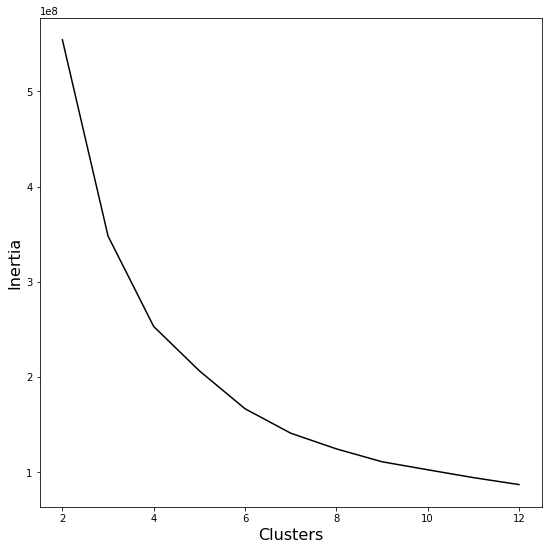

In [13]:
fig = plt.figure(figsize=(9, 9))
axis = fig.add_subplot(111, aspect='auto')
plt.plot(range(2, 13), inertia, 'k-')
plt.xlabel('Clusters', fontsize=16)
plt.ylabel('Inertia', fontsize=16)
plt.show()

Again, it appears that the "elbow" occurs around 7 clusters, although it isn't as clear-cut in this case. Nonetheless, let's proceed with 7 clusters again.

In [14]:
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(two_df[['LOC_X', 'LOC_Y']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

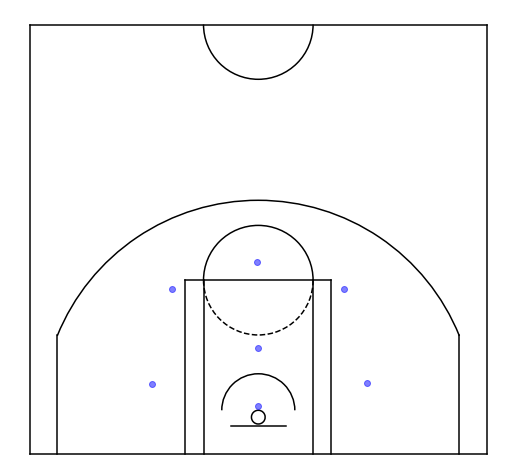

In [15]:
court, court_axis = draw_court()
for cent in kmeans.cluster_centers_:
    plt.plot(cent[0], cent[1], 'bo', alpha=0.5)

The above result is really interesting. By restricting the dataset to two-point field goals only, the 7 cluster centroids seem to contract towards the basket, almost uniformly. This maintains the structure and symmetry of the previous cluster locations. Let's see how the cluster sizes change.

In [16]:
preds = kmeans.predict(two_df[['LOC_X', 'LOC_Y']])
two_df['2pt_cluster'] = preds

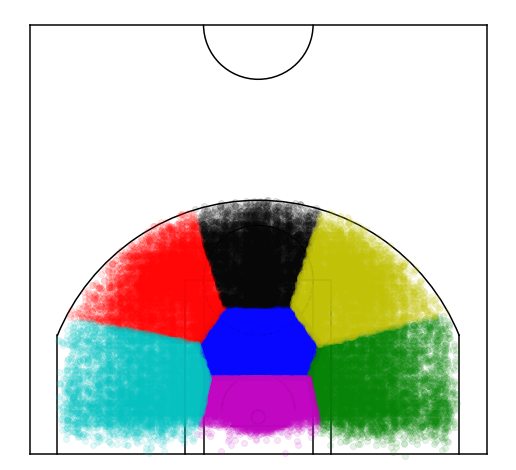

In [17]:
court, court_axis = draw_court()
cols = ['b', 'g', 'r', 'm', 'c', 'k', 'y']
for clust in range(0, 7):
    plt.plot(two_df[two_df['2pt_cluster']==clust]['LOC_X'], two_df[two_df['2pt_cluster']==clust]['LOC_Y'], cols[clust] + 'o', alpha=0.1)

As the centroid locations contracted towards the basket, the cluster sizes seem to have contracted as well. Interestingly, the relative shapes of each cluster seem to have persisted to these two-point field goal clusters. And, lastly, the five clusters radiating from the center overlap with portions of the painted area and seem to represent the midrange shot more fully.

### Three-point Field Goals

In [18]:
inertia = []
for clusters in range(2, 13):
    print(str(clusters) + ' Clusters')
    kmeans = KMeans(n_clusters=clusters, random_state=0)
    kmeans.fit(three_df[['LOC_X', 'LOC_Y']])
    print(kmeans.cluster_centers_)
    inertia.append(kmeans.inertia_)
    print('***************')

2 Clusters
[[-139.71225156  180.96833284]
 [ 154.27390964  168.6047532 ]]
***************
3 Clusters
[[ -64.575652    246.68729854]
 [ 174.44174397  150.98147805]
 [-216.87972465   83.95429919]]
***************
4 Clusters
[[-223.41777009   65.73104123]
 [ 123.02786676  224.89675402]
 [ 226.63151303   43.48388444]
 [ -97.09744241  237.8050789 ]]
***************
5 Clusters
[[-227.64198837   49.44764675]
 [   8.90532352  265.47390369]
 [-138.38637903  217.76714714]
 [ 228.65060804   31.72937325]
 [ 150.75605511  207.87241963]]
***************
6 Clusters
[[-149.20549378  209.9439062 ]
 [ 179.25019657  181.88111338]
 [ 229.48683537   23.24208585]
 [-228.39052603   45.57027449]
 [ -29.16039662  264.43409157]
 [  98.90806643  244.59971827]]
***************
7 Clusters
[[-229.78225555   34.74383005]
 [ 114.16903504  237.31656871]
 [ 229.55210828   21.88724623]
 [-108.82562873  239.81581625]
 [-182.53375338  178.42934293]
 [   2.79307344  266.83275322]
 [ 185.63196238  174.54998156]]
***********

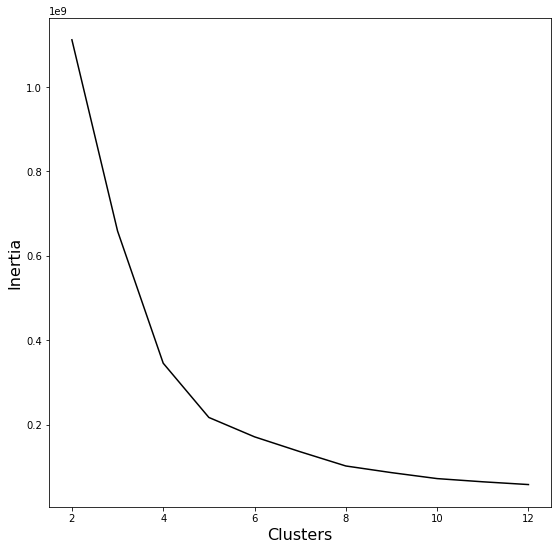

In [19]:
fig = plt.figure(figsize=(9, 9))
axis = fig.add_subplot(111, aspect='auto')
plt.plot(range(2, 13), inertia, 'k-')
plt.xlabel('Clusters', fontsize=16)
plt.ylabel('Inertia', fontsize=16)
plt.show()

The "elbow" here seems to jump out at 5 clusters for three-point field goals.

In [20]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(three_df[['LOC_X', 'LOC_Y']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

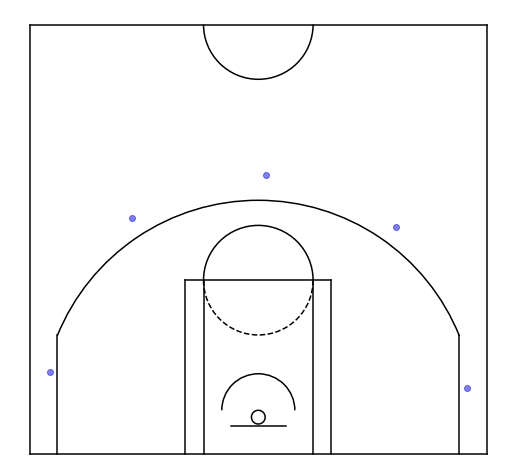

In [21]:
court, court_axis = draw_court()
for cent in kmeans.cluster_centers_:
    plt.plot(cent[0], cent[1], 'bo', alpha=0.5)

In opposite fashion to the two-point field goal centroids, these centroids have moved farther from the basket, which makes sense as the dataset is restricted to three-point field goals. The five clusters maintain symmetry around the basket and mimic the five outer clusters built on the entire dataset.

In [22]:
preds = kmeans.predict(three_df[['LOC_X', 'LOC_Y']])
three_df['3pt_cluster'] = preds

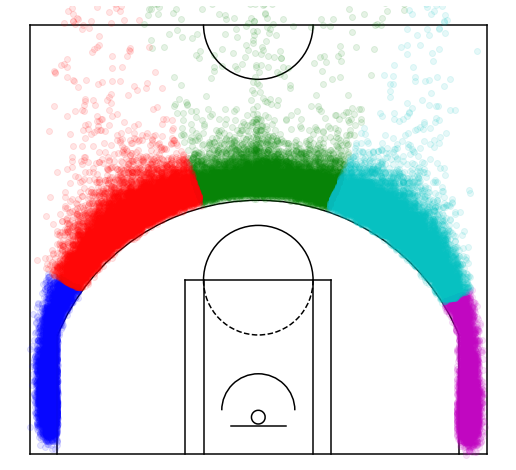

In [23]:
court, court_axis = draw_court()
cols = ['b', 'g', 'r', 'm', 'c', 'k', 'y']
for clust in range(0, 5):
    plt.plot(three_df[three_df['3pt_cluster']==clust]['LOC_X'], three_df[three_df['3pt_cluster']==clust]['LOC_Y'], cols[clust] + 'o', alpha=0.1)

The 5 three-point field goal clusters closely mirror the different types of three-pointers discussed at length across the NBA: corner threes (2 clusters) and above-the-break threes (three clusters).

As a last step, let's examine how individual players and teams distribute their shots across the clusters we've built.

## Player/Team Analysis

In [24]:
shot_df = shot_df.merge(two_df[['GAME_EVENT_ID', 'GAME_ID', '2pt_cluster']],
                        left_on=['GAME_EVENT_ID', 'GAME_ID'],
                        right_on=['GAME_EVENT_ID', 'GAME_ID'],
                        how='left')

shot_df = shot_df.merge(three_df[['GAME_EVENT_ID', 'GAME_ID', '3pt_cluster']],
                        left_on=['GAME_EVENT_ID', 'GAME_ID'],
                        right_on=['GAME_EVENT_ID', 'GAME_ID'],
                        how='left')

In [25]:
shot_df[['cluster', '2pt_cluster', '3pt_cluster']].head()

,cluster,2pt_cluster,3pt_cluster
0,5,NaN,1.0
1,1,NaN,4.0
2,0,3.0,NaN
3,0,3.0,NaN
4,0,3.0,NaN


The above shows that shots are assigned integer values to indicate the cluster to which they belong. These aren't very descriptive, so the following dictionaries map the cluster values to more descriptive terms describing the shot location. These were gathered by cross-referencing the colors of each cluster in the above figures to the cluster value.

In [26]:
three_pointer = {0: 'Right Corner',
                 1: 'Top of the Key',
                 2: 'Right Wing',
                 3: 'Left Corner',
                 4: 'Left Wing'}

two_pointer = {0: 'Painted Area',
               1: 'Left Baseline',
               2: 'Right Wing',
               3: 'Restricted Area',
               4: 'Right Baseline',
               5: 'Top of the Key',
               6: 'Left Wing'}

all_shots = {0: 'Restricted Area',
             1: 'Left Wing',
             2: 'Right Wing',
             3: 'Painted Area',
             4: 'Left Baseline',
             5: 'Top of the Key',
             6: 'Right Baseline'}

In [27]:
shot_df['cluster_name'] = [all_shots[x] for x in shot_df['cluster']]
shot_df['2pt_cluster_name'] = [two_pointer[x] if pd.notnull(x) else x for x in shot_df['2pt_cluster']]
shot_df['3pt_cluster_name'] = [three_pointer[x] if pd.notnull(x) else x for x in shot_df['3pt_cluster']]

In [28]:
shot_df[['cluster_name', '2pt_cluster_name', '3pt_cluster_name']].head()

,cluster_name,2pt_cluster_name,3pt_cluster_name
0,Top of the Key,NaN,Top of the Key
1,Left Wing,NaN,Left Wing
2,Restricted Area,Restricted Area,NaN
3,Restricted Area,Restricted Area,NaN
4,Restricted Area,Restricted Area,NaN


That's much better! Now, let's write a function to visualize how a player or team distributes their shots across the clusters. The following function `indiv_clusters` ingests a player/team ID and the type of clusters to use (all shots, two-point field goal attempts, or three-point field goal attempts) and produces a bar chart displaying the fraction of shots that fall within each cluster.

In [29]:
def indiv_clusters(id_val, player_or_team, cluster_type):
    """ This function ingests a player/team ID and the
    type of clusters to use (all shots, two-point field
    goal attempts, or three-point field goal attempts)
    and produces a bar chart displaying the fraction of
    shots that fall within each cluster

    @param id_val (int): Unique identifier for the player or
        team provided
    @param player_or_team (str): 'player' if id_val corresponds
        to a player, 'team' if id_val corresponds to a team
    @param cluster_type (str): One of "all", "2pt", or "3pt"
        indicating which type of clusters to use for the
        visualization

    Returns:

        - fig (matplotlib.figure.Figure): figure displaying
        the fraction of shots within each cluster
    """

    if player_or_team=='team':
        shot = shot_df[shot_df['TEAM_ID']==id_val]
        plot_title = shot['TEAM_NAME'].iloc[0]
    else:
        shot = shot_df[shot_df['PLAYER_ID']==id_val]
        plot_title = shot['PLAYER_NAME'].iloc[0]

    leg = plot_title

    if cluster_type == '2pt':
        shot = shot[pd.notnull(shot['2pt_cluster'])]
        group_df = pd.DataFrame(shot.groupby(['2pt_cluster_name',
                                              '2pt_cluster'])['GAME_ID'].count()).reset_index()
        plot_title += ' - 2pt FGA'

        league = shot_df[pd.notnull(shot_df['2pt_cluster'])]
        league_df = pd.DataFrame(league.groupby(['2pt_cluster_name',
                                                 '2pt_cluster'])['GAME_ID'].count()).reset_index()
    elif cluster_type == '3pt':
        shot = shot[pd.notnull(shot['3pt_cluster'])]
        group_df = pd.DataFrame(shot.groupby(['3pt_cluster_name',
                                              '3pt_cluster'])['GAME_ID'].count()).reset_index()
        plot_title += ' - 3pt FGA'

        league = shot_df[pd.notnull(shot_df['3pt_cluster'])]
        league_df = pd.DataFrame(league.groupby(['3pt_cluster_name',
                                                 '3pt_cluster'])['GAME_ID'].count()).reset_index()
    else:
        group_df = pd.DataFrame(shot.groupby(['cluster_name',
                                              'cluster'])['GAME_ID'].count()).reset_index()
        plot_title += ' - FGA'
        league_df = pd.DataFrame(shot_df.groupby(['cluster_name',
                                                  'cluster'])['GAME_ID'].count()).reset_index()

    group_df.columns = ['cluster_name', 'cluster', 'shots']
    group_df['cluster'] = [int(x) for x in group_df['cluster']]
    group_df['fraction'] = group_df['shots']/sum(group_df['shots'])

    league_df.columns = ['cluster_name', 'cluster', 'shots']
    league_df['cluster'] = [int(x) for x in league_df['cluster']]
    league_df['fraction'] = league_df['shots']/sum(league_df['shots'])

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')

    width = 0.35  # the width of the bars

    axis.bar([x - width/2 for x in group_df['cluster']],
             group_df['fraction'], width, color=[cols[x] for x in group_df['cluster']], label=leg + ' (Left)')
    axis.bar([x + width/2 for x in league_df['cluster']],
             league_df['fraction'], width, color=[cols[x] for x in league_df['cluster']], alpha=0.25, label='League (Right)')
    axis.set_ylabel('Fraction of Shots', fontsize=16)
    axis.set_title(plot_title, fontsize=16)
    axis.set_xticks(group_df['cluster'])
    axis.set_xticklabels(group_df['cluster_name'], rotation=45)
    axis.legend(fontsize=16)
    plt.ylim(0, 1)
    plt.show()

    return fig

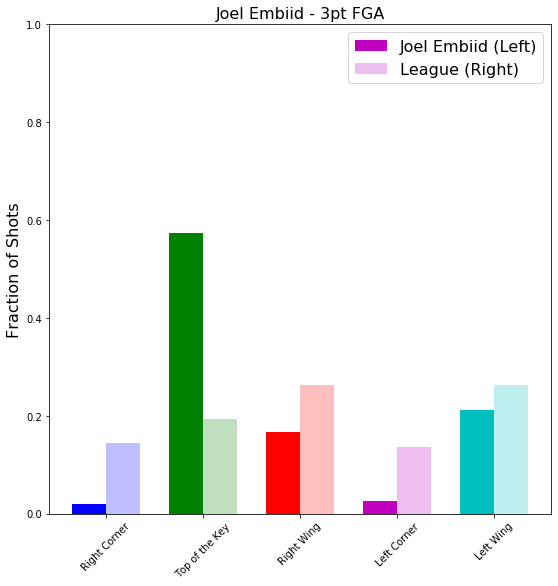

In [30]:
ex_fig = indiv_clusters(203954, 'player', '3pt')

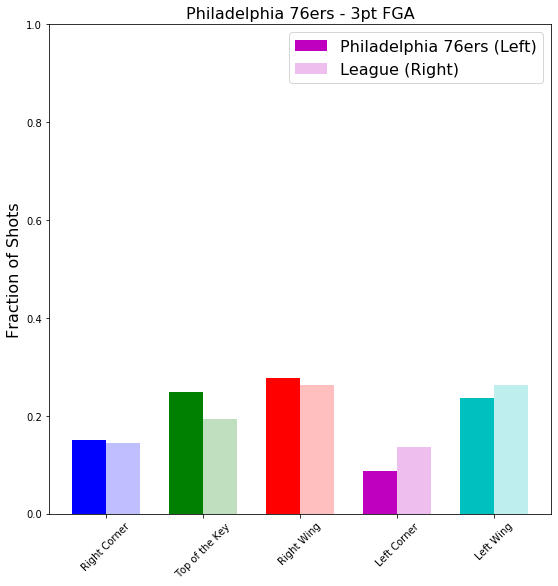

In [31]:
ex_fig = indiv_clusters(1610612755, 'team', '3pt')

Above, you can see how Joel Embiid and the 76ers distribute their three-point field goal attempts across clusters. Embiid clearly loves the above-the-break three-point field goal in the middle of the floor, which likely drives up the 76ers fraction of shots from that cluster.

## Conclusion

This notebook explores _k_-means clustering through the application of shot locations for NBA players and teams. Visualizing shots in this manner can give insight into how the league distributes field goal attempts, while also highlighting the offensive style or strategy of a team or player.

I feel as if this notebook could serve as a useful jumping off point for either further analysis or other applications of _k_-means clustering. I encourage the reader to pick up where this notebook leaves off!